# Metric
> metric

In [ ]:
import pyvista as pv

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True

In [ ]:
from zpinn.pinn_nf2_visualization import draw_grid

## Analytical Field

In [ ]:
import pickle

### NLFFF

In [ ]:
with open("b.pickle","rb") as f:
    b = pickle.load(f)

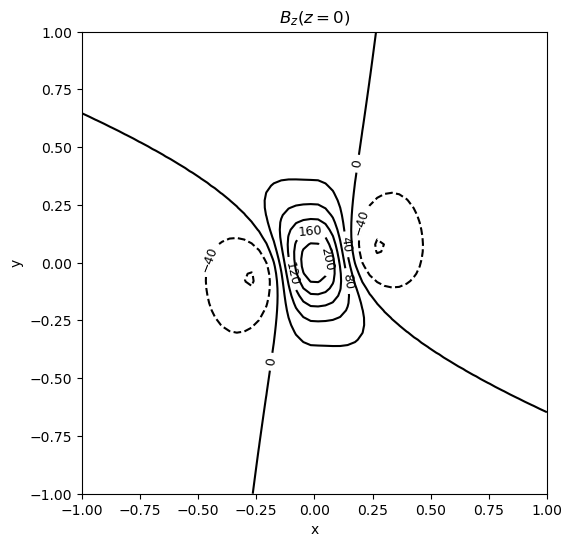

In [ ]:
bb = draw_grid(b.grid)
bb.plt_Bz()

### Potential Field

In [ ]:
from zpinn.pinn_nf2_potential import get_potential_field

In [ ]:
with open("bp.pickle","rb") as f:
    bp = pickle.load(f)

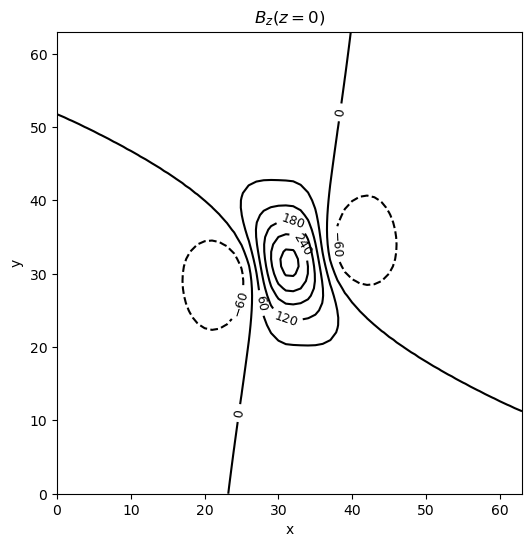

In [ ]:
bpbp = draw_grid(bp.grid)
bpbp.plt_Bz()

## Numerical Field

In [ ]:
from zpinn.pinn_nf2_cleanup import BModel
from zpinn.pinn_nf2_visualization import pinn_cube

In [ ]:
save_path = '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_010000.pt'

In [ ]:
B = pinn_cube(save_path)
B.calculate_magnetic_fields()

100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 82.14it/s]


UniformGrid (0x7f747742e9e0)
  N Cells:      250047
  N Points:     262144
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 6.300e+01
  Z Bounds:     0.000e+00, 6.300e+01
  Dimensions:   64, 64, 64
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

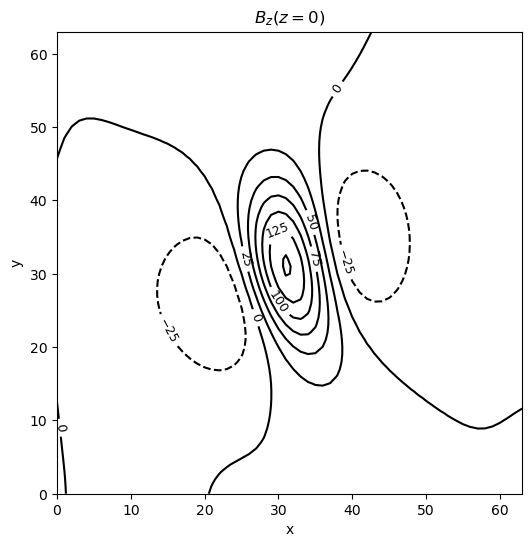

In [ ]:
BB = draw_grid(B.grid)
BB.plt_Bz()

In [ ]:
BB.pv_streamline()

Widget(value="<iframe src='/proxy/41791/index.html?ui=P_0x7f74606be170_1&reconnect=auto' style='width: 99%; he…

## Figures of merit

$$
C_\text{vec} = \frac{\sum_i \mathbf{B}_i \cdot \mathbf{b}_i}{(\sum_i |\mathbf{B}_i|^2 \sum_i |\mathbf{b}_i|^2)^{1/2}}
$$

$$
C_\text{CS} = \frac{1}{M} \sum_i \frac{\mathbf{B}_i \cdot \mathbf{b}_i}{|\mathbf{B}_i||\mathbf{b}_i|}
$$

$$
E'_n = 1 - \frac{\sum_i |\mathbf{B}_i - \mathbf{b}_i|}{\sum_i |\mathbf{b}_i|}
$$

$$
E'_m = 1 - \frac{1}{M} \frac{\sum_i |\mathbf{B}_i - \mathbf{b}_i|}{\sum_i |\mathbf{b}_i|}
$$

$$
\epsilon = \frac{\sum_i |\mathbf{B}_i|^2}{\sum_i |\mathbf{b}_i|^2}
$$

$$
\epsilon_p = \frac{\sum_i |\mathbf{B}_i|^2}{\sum_i |\mathbf{B}_{\text{p}, i}|^2}
$$

$$
\text{CW}_\text{sin} = \frac{\sum_i \frac{|\mathbf{J}_i \times \mathbf{B}_i|}{|\mathbf{B}_i|}}{\sum_i |\mathbf{J}_i|}
$$

In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
def vector_norm(vector):
    return np.sqrt((vector ** 2).sum(-1))
    
def divergence(b_field):  # (x, y, z, (xyz-field))
    div_B = np.stack([np.gradient(b_field[..., i], axis=i, edge_order=2) for i in range(3)], axis=-1).sum(-1)
    return div_B

def curl(b_field):  # (x, y, z)
    _, dFx_dy, dFx_dz = np.gradient(b_field[..., 0], axis=[0, 1, 2], edge_order=2)
    dFy_dx, _, dFy_dz = np.gradient(b_field[..., 1], axis=[0, 1, 2], edge_order=2)
    dFz_dx, dFz_dy, _ = np.gradient(b_field[..., 2], axis=[0, 1, 2], edge_order=2)

    rot_x = dFz_dy - dFy_dz
    rot_y = dFx_dz - dFz_dx
    rot_z = dFy_dx - dFx_dy

    return np.stack([rot_x, rot_y, rot_z], -1)

In [ ]:
def metrics(B, b, B_potential):
    """
    B is the numerical solution
    b is the reference magnetic field
    """

    c_vec = np.sum((B * b).sum(-1)) / np.sqrt((B ** 2).sum(-1).sum() * (b ** 2).sum(-1).sum())

    M = np.prod(B.shape[:-1])
    c_cs = (1 / M) * np.sum((B * b).sum(-1) / (vector_norm(B)*vector_norm(b)))

    E_n = vector_norm(B - b).sum() / vector_norm(b).sum()

    E_m = (1 / M) * (vector_norm(B - b) / vector_norm(b)).sum()

    eps = (vector_norm(B) ** 2).sum() / (vector_norm(b) ** 2).sum()

    eps_p = (vector_norm(B) ** 2).sum() / (vector_norm(B_potential) ** 2).sum()

    j = curl(B)
    sig_J = (vector_norm(np.cross(j, B, -1)) / vector_norm(B)).sum() / vector_norm(j).sum()
    L1 = (vector_norm(np.cross(j, B, -1)) ** 2 / vector_norm(B) ** 2).mean()
    L2 = (divergence(B) ** 2).mean()
    curlB = vector_norm(j).sum() / vector_norm(curl(b)).sum()

    key = ["C_vec", "C_cs", "1-En", "1-Em", "eps", "eps_p", "sig_J", "L1", "L2", "curlB"]
    metric = [c_vec, c_cs, 1-E_n, 1-E_m, eps, eps_p, sig_J, L1, L2, curlB]
    return dict(zip(key, metric))

In [ ]:
def metric_df(B, b, B_potential, iteration):
    metric = metrics(B=B, b=b, B_potential=B_potential)
    iterinfo = {'iteration': iteration}
    metric = {**iterinfo, **metric}

    df = pd.DataFrame.from_dict([metric])
    return df

In [ ]:
B_array = B.grid['B'].reshape(B.grid.dimensions[0], B.grid.dimensions[1], B.grid.dimensions[2], 3)
b_array = b.grid['B'].reshape(b.grid.dimensions[0], b.grid.dimensions[1], b.grid.dimensions[2], 3)
bp_array = bp.grid['B'].reshape(bp.grid.dimensions[0], bp.grid.dimensions[1], bp.grid.dimensions[2], 3)

In [ ]:
df_b = metric_df(B=b_array, b=b_array, B_potential=bp_array, iteration=-2)
df_b

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.0,1.0,1.0,1.0,1.0,1.338328,0.8792,9.444083,7.58767,1.0


In [ ]:
df_bp = metric_df(B=bp_array, b=b_array, B_potential=bp_array, iteration=-1)
df_bp

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-1,0.875328,0.89587,0.442081,0.367068,0.747201,1.0,0.94423,28.87552,8.25042,1.018415


In [ ]:
df = pd.concat([df_b, df_bp], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.00000,1.000000,1.000000,1.000000,1.338328,0.87920,9.444083,7.58767,1.000000
1,-1,0.875328,0.89587,0.442081,0.367068,0.747201,1.000000,0.94423,28.875520,8.25042,1.018415


In [ ]:
df_new = metric_df(B=B_array, b=b_array, B_potential=bp_array, iteration=B.state['iteration'])
df = pd.concat([df, df_new], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.338328,0.87920,9.444083,7.587670,1.000000
1,-1,0.875328,0.895870,0.442081,0.367068,0.747201,1.000000,0.94423,28.875520,8.250420,1.018415
2,0,-0.002355,0.007711,-0.562951,-2.769390,0.166806,0.223241,0.77925,0.000036,0.000011,0.008803


In [ ]:
metric_file = 'metric.csv'
df.to_csv(metric_file, index=False)

### Figures of metric (batch)

In [ ]:
import os
import glob

In [ ]:
field_files = os.path.join(os.path.dirname(save_path),'model_0*.pt')
field_files = sorted(glob.glob(field_files))
field_files

['/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_000000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_001000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_002000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_003000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_004000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_005000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_006000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_007000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_008000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_009000.pt',
 '/home/tensor/workspace/Python_stuff/zpinn/nbs/results/model_010000.pt']

In [ ]:
df_b = metric_df(B=b_array, b=b_array, B_potential=bp_array, iteration=-2)
df_bp = metric_df(B=bp_array, b=b_array, B_potential=bp_array, iteration=-1)
df = pd.concat([df_b, df_bp], ignore_index=True)

In [ ]:
for field_path in field_files:
    B = pinn_cube(field_path)
    B.calculate_magnetic_fields()
    B_array = B.grid['B'].reshape(B.grid.dimensions[0], B.grid.dimensions[1], B.grid.dimensions[2], 3)
    df_new = metric_df(B=B_array, b=b_array, B_potential=bp_array, iteration=B.state['iteration'])
    df = pd.concat([df, df_new], ignore_index=True)
df

100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 314.82it/s]


,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,-2,1.000000,1.000000,1.000000,1.000000,1.000000,1.338328,0.879200,9.444083,7.587670,1.000000
1,-1,0.875328,0.895870,0.442081,0.367068,0.747201,1.000000,0.944230,28.875520,8.250420,1.018415
2,0,-0.002355,0.007711,-0.562951,-2.769390,0.166806,0.223241,0.779250,0.000036,0.000011,0.008803
3,1000,0.536020,0.324754,-0.264630,-1.619794,0.594503,0.795640,0.925169,0.977365,1.066032,0.947513
4,2000,0.537253,0.362893,-0.488930,-2.054682,1.182131,1.582079,0.900648,2.664320,3.066307,1.359623
5,3000,0.566381,0.157406,-0.590911,-2.518032,1.273719,1.704654,0.895272,2.932265,3.641409,1.368881
6,4000,0.610004,0.140037,-0.460864,-2.091269,1.261431,1.688209,0.906294,3.270299,4.089660,1.296145
7,5000,0.705828,0.136645,-0.177996,-1.266343,1.212503,1.622726,0.932267,3.736429,4.457525,1.161082
8,6000,0.779679,0.505295,0.120884,-0.434519,1.005903,1.346228,0.937224,3.607898,3.984798,1.007156
9,7000,0.811307,0.206710,0.171146,-0.487712,0.928684,1.242883,0.938862,3.758956,3.839471,0.948433
